In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
sns.set()

In [10]:
df = pd.read_csv('Experimento.csv')
df.head()

,[run number],maximum-sugar-endowment,minimum-sugar-endowment,visualization,initial-population,[step],avg-gini,starvation
0,1,0,0,color-agents-by-decile,400,0,0.0,0
1,2,0,10,color-agents-by-decile,400,0,0.0,0
2,3,0,20,color-agents-by-decile,400,0,0.0,0
3,4,0,30,color-agents-by-decile,400,0,0.0,0
4,5,0,40,color-agents-by-decile,400,0,0.0,0


In [11]:
df = df.drop(columns='visualization')
df = df.drop(df[df['[step]'] == 0].index) # aquellas runs que no se iniciaron
df = df.drop(columns='[run number]')
df = df.drop(columns='initial-population') #poblacion fija
df = df.drop(columns='[step]') # en este punto, todas las runs son validas y llegaron a la it final
df

,maximum-sugar-endowment,minimum-sugar-endowment,avg-gini,starvation
21,10,0,0.503033,6253
42,20,0,0.492501,5426
43,20,10,0.463636,4651
63,30,0,0.464623,4949
64,30,10,0.450502,4096
...,...,...,...,...
435,200,150,0.192826,380
436,200,160,0.185226,401
437,200,170,0.189619,351
438,200,180,0.184167,321


In [12]:
#df.info()
#df.describe()
#df.columns
df.shape

(210, 4)

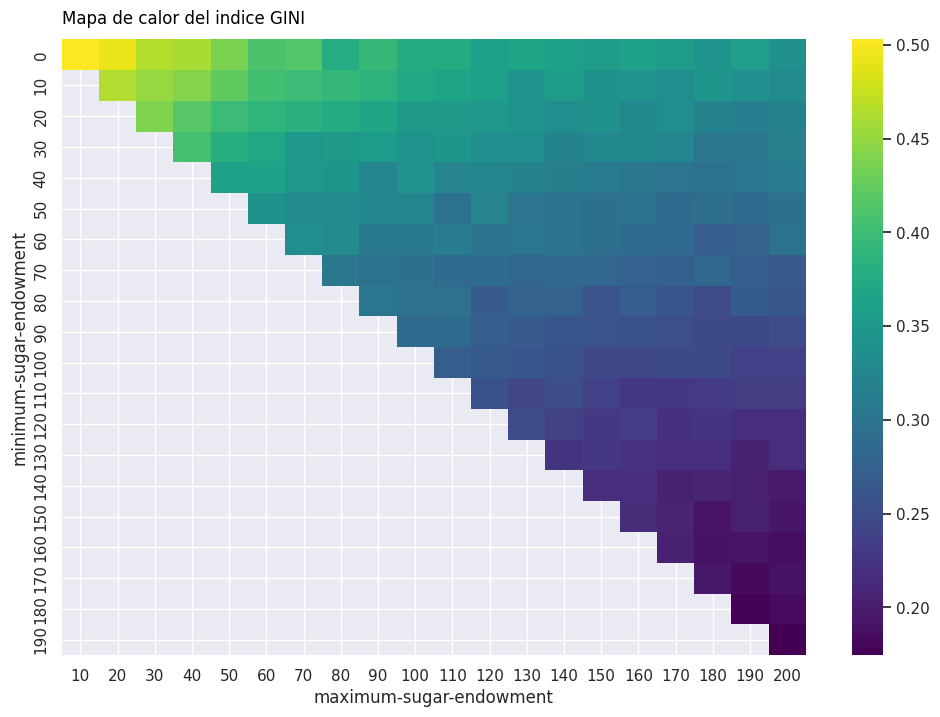

In [13]:
datos_aplanados = df.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values="avg-gini")
plt.figure(figsize=(12, 8)) 
sns.heatmap(datos_aplanados, cmap='viridis',annot=False)
plt.text(0, -0.5, 'Mapa de calor del indice GINI', fontsize=12, color='black', ha='left')
plt.savefig('Mapa de calor GINI.png',dpi=300, bbox_inches='tight')
plt.show()

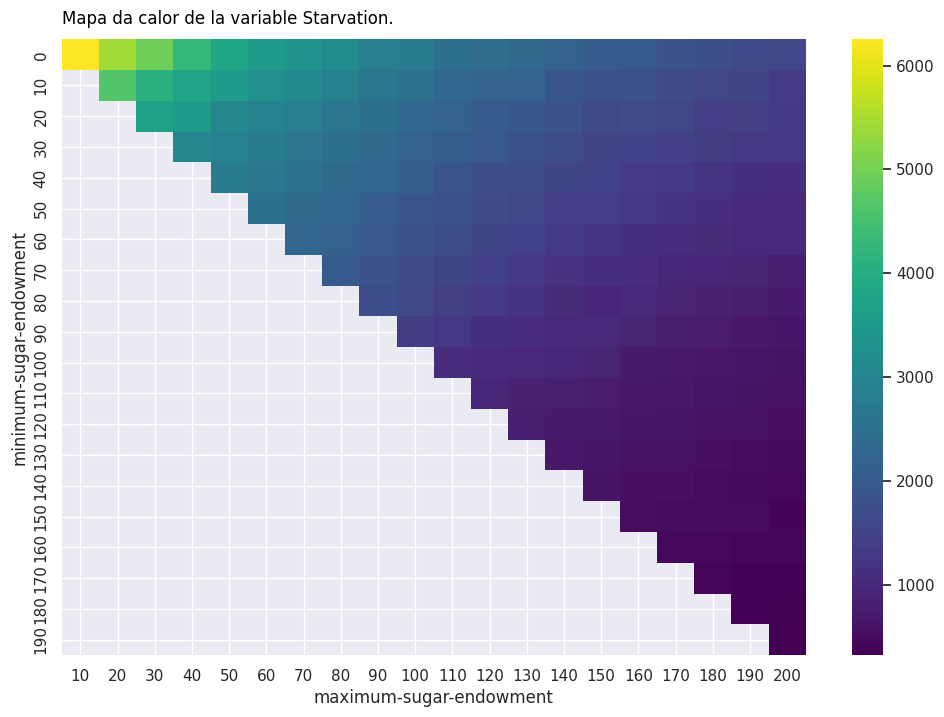

In [14]:

#La visualizacion del valor starvation ahora es mejor
plt.figure(figsize=(12, 8)) 
datos_aplanados = df.pivot(index="minimum-sugar-endowment", columns="maximum-sugar-endowment", values="starvation")
sns.heatmap(datos_aplanados, cmap='viridis',annot=False)
plt.text(0, -0.5, 'Mapa da calor de la variable Starvation.', fontsize=12, color='black', ha='left')
plt.savefig('Mapa de calor Starvation.png',dpi=300, bbox_inches='tight')
plt.show()

In [15]:
correlacion = df['avg-gini'].corr(df['starvation'])
print(correlacion)

0.9477878987092091
